# **Object Detection For Autonomous Driving**


Self-driving cars are becoming more prevalent in the modern transportation system. We think that it would be interesting to understand how these vehicles can recognize objects on the road and navigate through the environment. A critical aspect of autonomous driving technology is object detection, which is the process of recognizing and responding to various elements on the road, such as pedestrians, cyclists, trucks, and others. Our goal for this project is to classify objects in images into one of 9 categories and understand how object detection works in autonomous driving.

# **Dataset**

We used the KITTI (Karlsruhe Institute of Technology and Toyota Technological Institute) dataset [1]. It is 5.79 GB with 7,481 labeled images in total. The dataset has 9 classes: Car, Cyclist, Pedestrian, Truck, Van, Tram, People_sitting, Misc, and DontCare. To process the data, we first converted the data labels into the YOLO format, which is a format that can be recognized by the YOLO model that we are using for object detection. We then splitted the dataset into 80% training, 10% validation, and 10% test sets.

In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
import os 

In [ ]:
# Check if CUDA is available, print the device name
if torch.cuda.is_available():
    device = 0  # Use the first GPU
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version (reported by PyTorch): {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version (reported by PyTorch): 12.6
GPU device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
import torchvision
print(f"TorchVision version: {torchvision.__version__}")

TorchVision version: 0.21.0+cu126


# YAML Files

YOLO works with data files in the yaml format to specify tasks and paths to train, validation, and test data. The following shows the content of the yaml files.

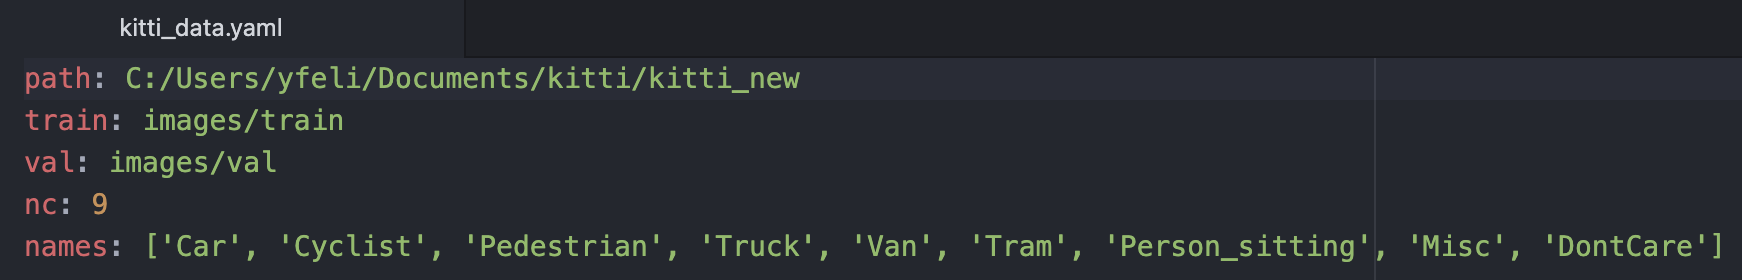

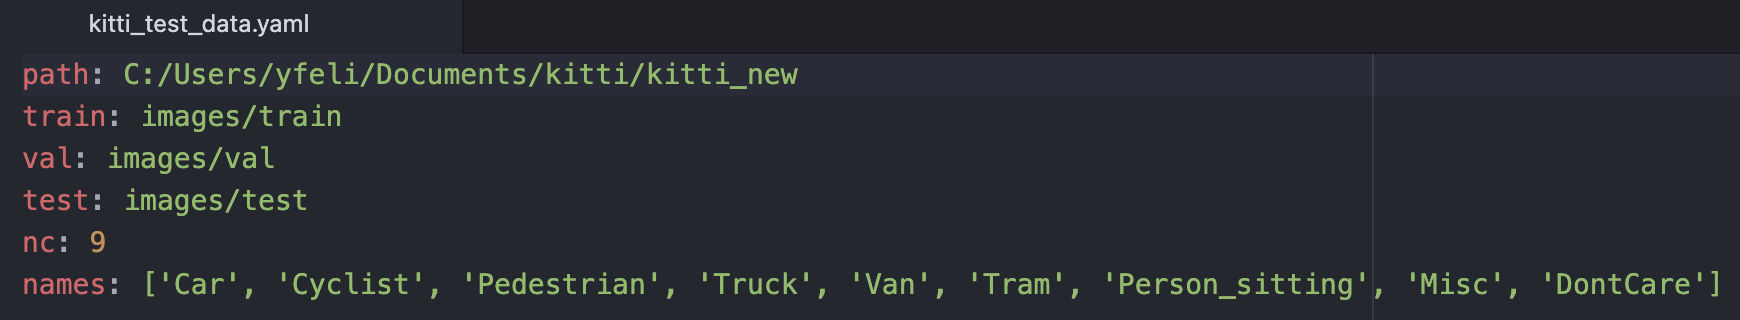

# Convert Labels from KITTI Format to YOLO Format

In [ ]:
import argparse
import logging
import os
from pathlib import Path

In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
KITTI_CLASS_MAP = {
    'Car':0, 'Cyclist': 1, 'Pedestrian': 2, 'Truck': 3,
    'Van': 4, 'Tram': 5, 'Person_sitting': 6, 'Misc': 7, 'DontCare': 8
}

CLASSES_TO_IGNORE = []

In [ ]:
def get_image_size(image_path):
    """Gets the width and height of an image using Pillow."""
    try:
        with Image.open(image_path) as img:
            return img.size  # Returns (width, height)
    except FileNotFoundError:
        logging.warning(f"Image file not found: {image_path}")
        return None
    except Exception as e:
        logging.error(f"Error opening or reading image {image_path}: {e}")
        return None

In [ ]:
def convert_kitti_to_yolo(kitti_label_path, image_dir, yolo_label_path):
    """
    Converts a single KITTI label file to YOLO format.

    Args:
        kitti_label_path (Path): Path to the input KITTI label file.
        image_dir (Path): Path to the directory containing corresponding images.
        yolo_label_path (Path): Path where the output YOLO label file should be saved.

    Returns:
        bool: True if conversion was successful and file was written, False otherwise.
    """
    base_filename = kitti_label_path.stem
    # Construct paths for both .png and .jpg image extensions
    image_path_png = image_dir / f"{base_filename}.png"
    image_path_jpg = image_dir / f"{base_filename}.jpg"

    # Determine which image path exists
    if image_path_png.exists():
        image_path = image_path_png
    elif image_path_jpg.exists():
        image_path = image_path_jpg
    else:
        logging.warning(f"Image not found for label {kitti_label_path.name} (checked .png and .jpg extensions)")
        return False

    img_size = get_image_size(image_path)
    if img_size is None:
        logging.warning(f"Could not get size for image {image_path.name}. Skipping label {kitti_label_path.name}.")
        return False

    img_w, img_h = img_size
    yolo_lines = []

    try:
        with open(kitti_label_path, 'r') as f_kitti:
            for line in f_kitti:
                parts = line.strip().split()
                if not parts:
                    continue

                class_name = parts[0]

                # Skip ignored classes
                if class_name in CLASSES_TO_IGNORE:
                    continue

                # Check if the class is in our map
                if class_name not in KITTI_CLASS_MAP:
                    logging.warning(f"Unmapped class '{class_name}' in {kitti_label_path.name}. Define it in KITTI_CLASS_MAP or add to CLASSES_TO_IGNORE. Skipping object.")
                    continue

                yolo_class_index = KITTI_CLASS_MAP[class_name]

                try:
                    # KITTI bbox format: left, top, right, bottom (indices 4, 5, 6, 7)
                    left = float(parts[4])
                    top = float(parts[5])
                    right = float(parts[6])
                    bottom = float(parts[7])
                except (IndexError, ValueError) as e:
                    logging.warning(f"Could not parse bounding box values in line: '{line.strip()}' from {kitti_label_path.name}. Error: {e}. Skipping object.")
                    continue

                # --- Convert KITTI bbox to YOLO format ---
                # Calculate center coordinates, width, and height
                bbox_width = right - left
                bbox_height = bottom - top
                center_x = left + bbox_width / 2.0
                center_y = top + bbox_height / 2.0

                # Normalize coordinates by image dimensions
                norm_center_x = center_x / img_w
                norm_center_y = center_y / img_h
                norm_width = bbox_width / img_w
                norm_height = bbox_height / img_h

                # Clamp values strictly between 0.0 and 1.0
                # (YOLO format expects values in this range)
                norm_center_x = max(0.0, min(1.0, norm_center_x))
                norm_center_y = max(0.0, min(1.0, norm_center_y))
                norm_width = max(0.0, min(1.0, norm_width))
                norm_height = max(0.0, min(1.0, norm_height))

                # Append the formatted YOLO line
                # Format: <class_index> <center_x_norm> <center_y_norm> <width_norm> <height_norm>
                yolo_lines.append(f"{yolo_class_index} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

        # Write the YOLO label file only if it contains valid objects
        if yolo_lines:
            # Ensure the output directory exists
            yolo_label_path.parent.mkdir(parents=True, exist_ok=True)
            with open(yolo_label_path, 'w') as f_yolo:
                f_yolo.write("\n".join(yolo_lines) + "\n") # Add trailing newline
            return True
        else:
            # Log if a label file resulted in no objects
            # logging.info(f"No target objects found or kept in {kitti_label_path.name}. No YOLO file created.")
            return False # Indicate that no file was written

    except Exception as e:
        logging.error(f"Failed to process file {kitti_label_path}: {e}")
        return False


In [ ]:
kitti_label_dir = "/kitti/labels"
image_dir = "/kitti/images_2"
yolo_output_dir = "/kitti/yolo_labels"

In [ ]:
if not kitti_label_dir.is_dir():
    logging.error(f"KITTI label directory not found or is not a directory: {kitti_label_dir}")
    return
if not image_dir.is_dir():
    logging.error(f"Image directory not found or is not a directory: {image_dir}")
    return

In [ ]:
# --- Start Conversion ---
logging.info(f"Starting KITTI to YOLO conversion...")
logging.info(f"Source KITTI Labels: {kitti_label_dir}")
logging.info(f"Source Images:       {image_dir}")
logging.info(f"Target YOLO Labels:  {yolo_output_dir}")
logging.info(f"Using Class Map:     {KITTI_CLASS_MAP}")
logging.info(f"Ignoring Classes:    {CLASSES_TO_IGNORE}")

# Create the main output directory if it doesn't exist
yolo_output_dir.mkdir(parents=True, exist_ok=True)

processed_count = 0
skipped_count = 0

kitti_label_files = list(kitti_label_dir.glob('*.txt'))
total_files = len(kitti_label_files)

if total_files == 0:
    logging.warning(f"No .txt label files found in {kitti_label_dir}. Exiting.")
    return

logging.info(f"Found {total_files} KITTI label files to process.")

# --- Process Each Label File ---
for i, label_file in enumerate(kitti_label_files):
    yolo_filename = f"{label_file.stem}.txt"
    yolo_filepath = yolo_output_dir / yolo_filename

    success = convert_kitti_to_yolo(label_file, image_dir, yolo_filepath)

    if success:
        processed_count += 1
    else:
        skipped_count += 1 # File skipped due to missing image, error, or no target objects

    # Log progress periodically
    if (i + 1) % 100 == 0 or (i + 1) == total_files:
        logging.info(f"Processed {i+1}/{total_files} files...")

# --- Final Summary ---
logging.info("Conversion finished.")
logging.info(f"Successfully generated YOLO label files: {processed_count}")
logging.info(f"Files skipped (no image/error/no target objects): {skipped_count}")
logging.info(f"YOLO labels saved to: {yolo_output_dir}")


# Split Data into Train, Val, Test

In [ ]:
import random
import shutil

In [ ]:
def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.8, random_seed=42):
    """
    Separates image and label files into training and validation sets.

    Args:
        image_dir (str): Path to the directory containing image files.
        label_dir (str): Path to the directory containing corresponding label files.
        output_dir (str): Path to the directory where train and val subdirectories will be created.
        train_ratio (float): The proportion of data to use for training (default: 0.8).
        random_seed (int): Seed for the random number generator for reproducibility (default: 42).
    """
    random.seed(random_seed)
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    label_files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]

    # Ensure the number of images and labels match
    if len(image_files) != len(label_files):
        print(f"Warning: Number of image files ({len(image_files)}) does not match the number of label files ({len(label_files)}).")

    # Sort the files to ensure consistent pairing
    image_files.sort()
    label_files.sort()

    # Create output directories if they don't exist

    train_image_dir = Path(output_dir) / 'images' / 'train'
    train_label_dir = Path(output_dir) / 'labels' / 'train'
    val_image_dir = Path(output_dir) / 'images' / 'val'
    val_label_dir = Path(output_dir) / 'labels' / 'val'
    test_image_dir = Path(output_dir) / 'images' / 'test'
    test_label_dir = Path(output_dir) / 'labels' / 'test'

    train_image_dir.mkdir(parents=True, exist_ok=True)
    train_label_dir.mkdir(parents=True, exist_ok=True)
    val_image_dir.mkdir(parents=True, exist_ok=True)
    val_label_dir.mkdir(parents=True, exist_ok=True)
    test_image_dir.mkdir(parents=True, exist_ok=True)
    test_label_dir.mkdir(parents=True, exist_ok=True)

    # Shuffle the image files to ensure random splitting
    random.shuffle(image_files)

    # Determine the split point
    num_train = int(len(image_files) * train_ratio)
    num_val = int(len(image_files)*((1-train_ratio)/2))
    train_images = image_files[:num_train]
    val_images = image_files[num_train:num_train+num_val]
    test_images = image_files[num_train+num_val:]

    print(f"Splitting dataset with a train ratio of {train_ratio}")
    print(f"Number of training samples: {len(train_images)}")
    print(f"Number of validation samples: {len(val_images)}")
    print(f"Number of test samples: {len(test_images)}")

    # Move training files
    for image_file in train_images:
        image_path = Path(image_dir) / image_file
        label_file = Path(label_dir) / image_file.replace(Path(image_file).suffix, '.txt') # Since label extension is .txt
        if label_file.exists():
            label_path = label_file
            shutil.copy(image_path, train_image_dir / image_file)
            shutil.copy(label_path, train_label_dir / label_file.name)
        else:
            print(f"Warning: Corresponding label file not found for {image_file}")

    # Move validation files
    for image_file in val_images:
        image_path = Path(image_dir) / image_file
        label_file = Path(label_dir) / image_file.replace(Path(image_file).suffix, '.txt') # Since label extension is .txt
        if label_file.exists():
            label_path = label_file
            shutil.copy(image_path, val_image_dir / image_file)
            shutil.copy(label_path, val_label_dir / label_file.name)
        else:
            print(f"Warning: Corresponding label file not found for {image_file}")

    # Move test files
    for image_file in test_images:
        image_path = Path(image_dir) / image_file
        label_file = Path(label_dir) / image_file.replace(Path(image_file).suffix, '.txt')
        if label_file.exists():
            label_path = label_file
            shutil.copy(image_path, test_image_dir / image_file)
            shutil.copy(label_path, test_label_dir / label_file.name)
        else:
            print(f"Warning: Corresponding label file not found for {image_file}")

    print("Dataset splitting complete.")

In [ ]:
image_directory = "/kitti/images_2"
label_directory = "/kitti/labels"
output_directory = "/kitti/kitti_new"
train_proportion = 0.8

split_dataset(image_directory, label_directory, output_directory, train_ratio=train_proportion)

# **Model**

Our model is YOLOv8n (You Only Look Once Version 8 Nano) from Ultralytics [2]. The model is built on the CNN architecture.

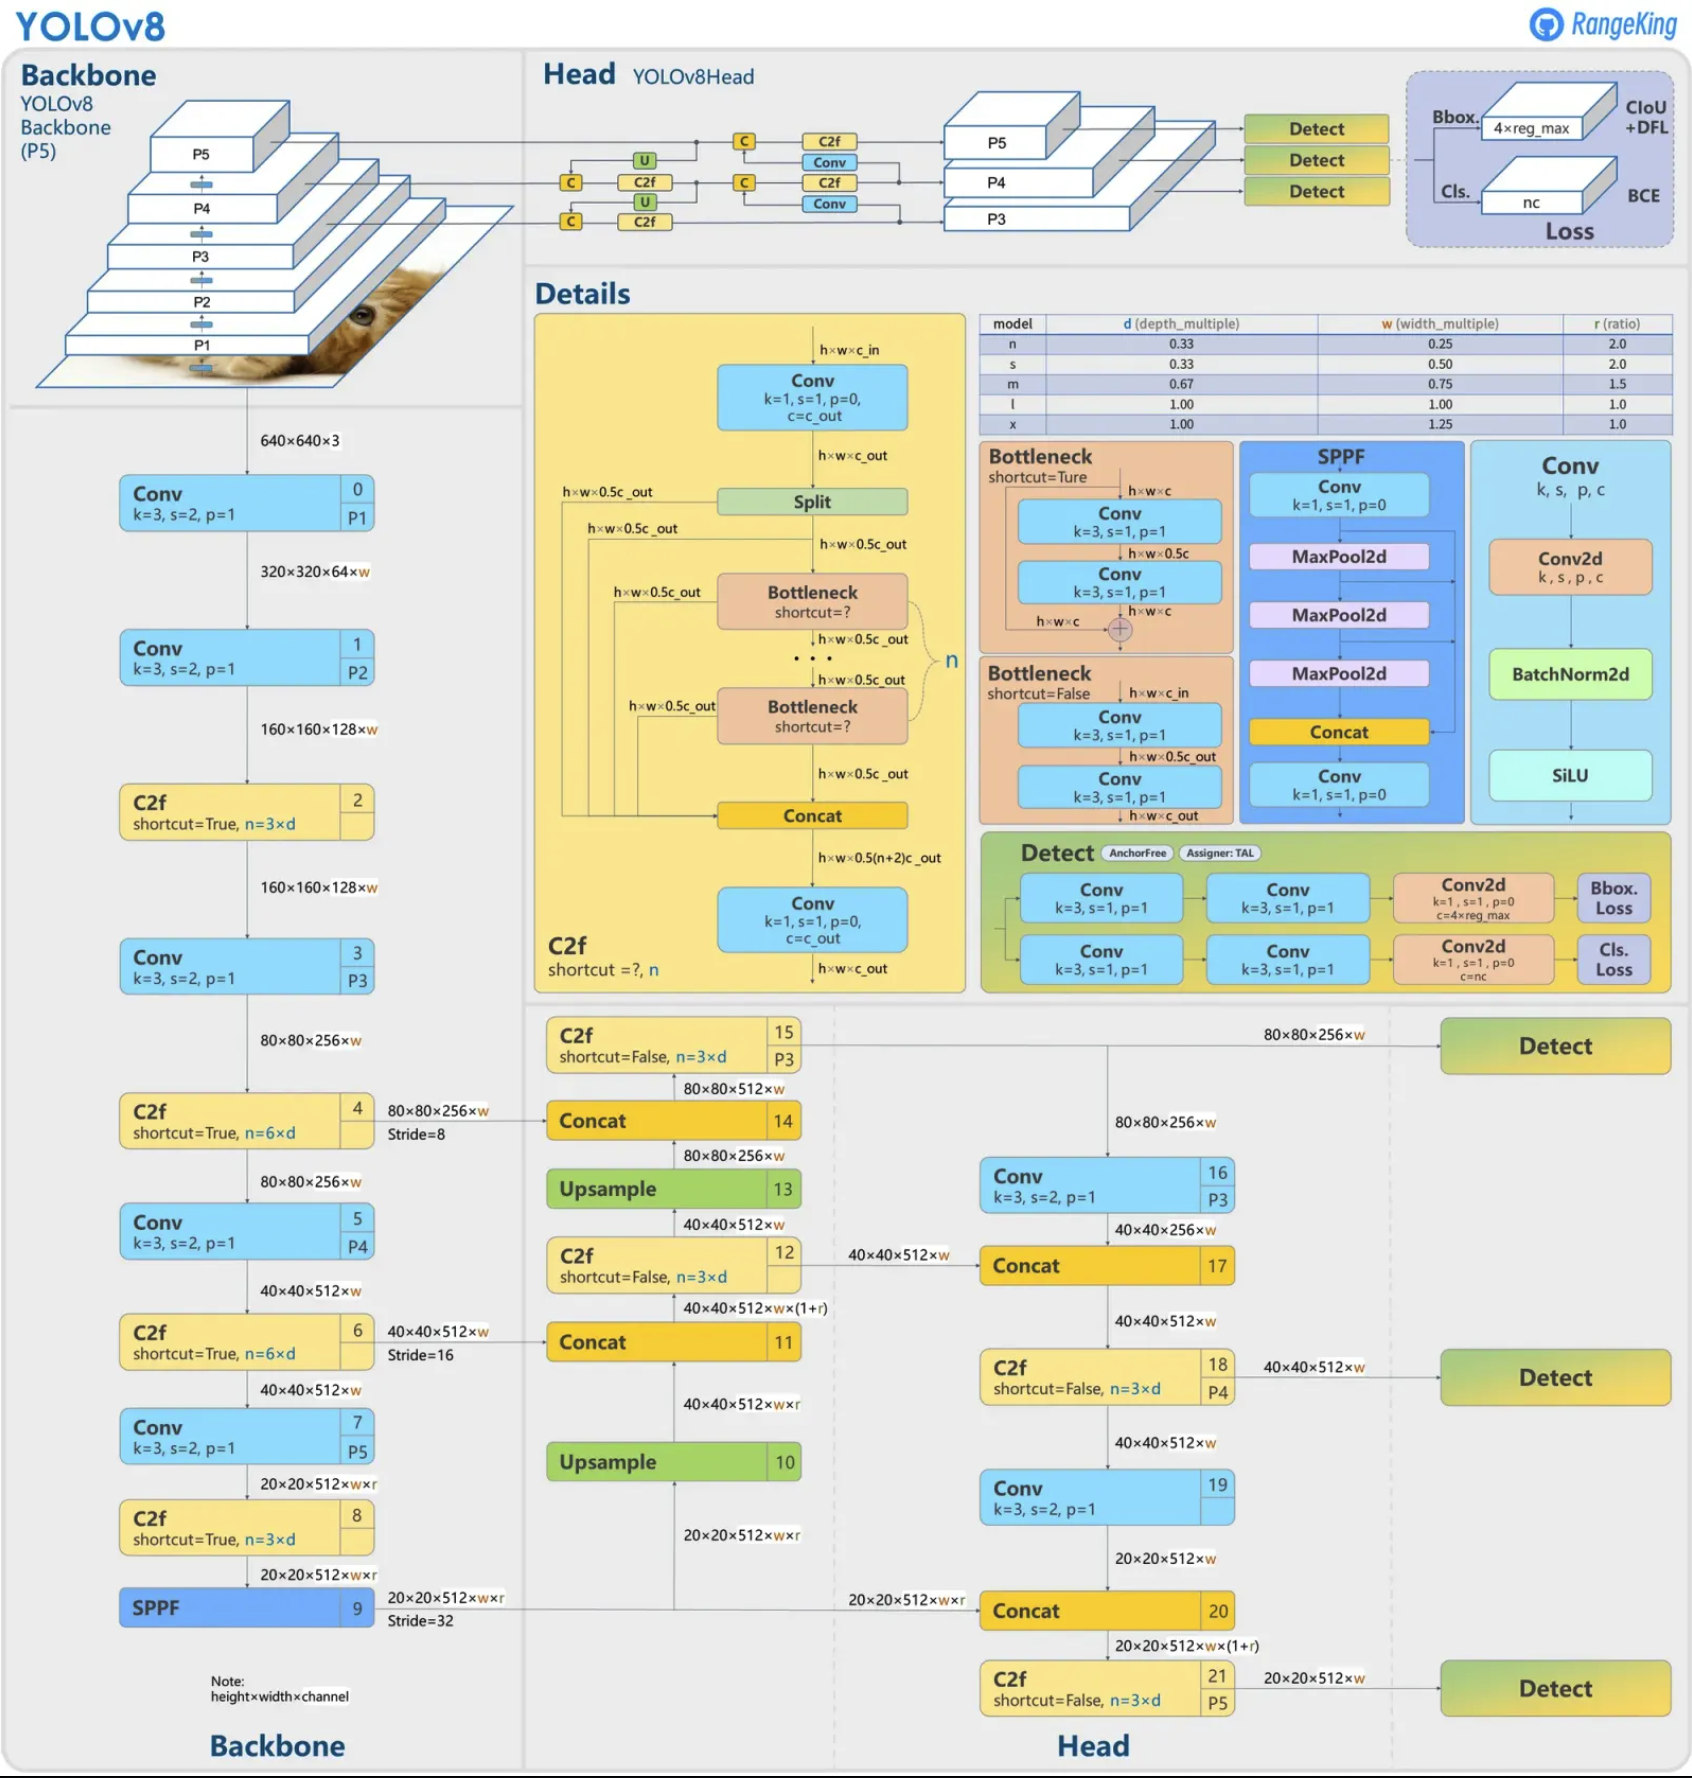

Image Source: https://blog.roboflow.com/what-is-yolov8/

The model employs convolutional layers and blocks such as C2f and SPPF. C2f is a Cross Stage Partial with Fusion block that will split the input into two, apply convolutionals (in the form of another block, Bottleneck, which comprises convolutional layers), and leave the other part unchanged, and then fuse (concatenate) the two parts later. The purpose is to allow the model to reuse features. The SPPF (Spatial Pyramid Pooling - Fast) block aggregates features from different regions and combines these local features with the model's global understanding of the image. This is done to capture multi-scale features. The model also employs Upsample, which increases the spatial resolution of the images. This is to combine low-resolution deep features with high-resolution shallow features for precise localization.

In [ ]:
# Load the pretrained YOLOv8n model
model = YOLO('yolov8n.pt')


train_args = {
    'data': '/kitti/kitti_data.yaml',
    'task': 'val',
    'epochs': 100,
    'batch': 16,
    'imgsz': 640,
    'patience': 20,    # Early stopping patience
    'project': 'kitti_yolov8n_may2_trial2',
    'name': 'yolov8n_train_val_test_may2',
    'device': device
}

# **Training**

In [ ]:
# Train model
results = model.train(**train_args)

New https://pypi.org/project/ultralytics/8.3.123 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.111  Python-3.13.0 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: task=val, mode=train, model=yolov8n.pt, data=C:/Users/yfeli/Documents/kitti/kitti_data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=kitti_yolov8n_may2_trial2, name=yolov8n_train_val_test_may2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

train: Scanning C:\Users\yfeli\Documents\kitti\kitti_new\labels\train.cache... 5984 images, 0 backgrounds, 0 corrupt: 1


val: Fast image access  (ping: 1.12.2 ms, read: 804.1170.7 MB/s, size: 721.3 KB)


val: Scanning C:\Users\yfeli\Documents\kitti\kitti_new\labels\val.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|█


Plotting labels to kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.32G      1.507      1.943      1.112        254        640: 100%|██████████| 374/374 [00:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.481      0.334       0.33      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.35G      1.365      1.256      1.069        194        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.484      0.445      0.427      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.35G      1.325       1.12      1.064        201        640: 100%|██████████| 374/374 [00:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.543        0.5      0.495      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.35G      1.297      1.039      1.054        241        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.622      0.458       0.53      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.35G      1.255      0.973      1.042        219        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.652       0.49      0.565       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.35G       1.23     0.9271      1.032        239        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.636       0.56      0.562      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.36G      1.208     0.9006      1.024        215        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.615      0.587      0.611      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.195     0.8697       1.02        258        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.632      0.603      0.634      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.36G      1.178     0.8532      1.016        184        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.671      0.589      0.632      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.36G      1.168     0.8352      1.011        199        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.612      0.611      0.646      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.36G       1.15     0.8094      1.003        151        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.648      0.588      0.625        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.36G       1.14     0.8018     0.9998        152        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.736      0.581      0.665      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.36G      1.134      0.791     0.9986        230        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.762      0.581      0.673      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.36G      1.116     0.7743      0.992        211        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.778      0.599      0.688      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.36G      1.108     0.7607     0.9888        197        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.733      0.618      0.687      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.36G      1.106     0.7601     0.9884        181        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.742      0.609      0.696      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.36G      1.087     0.7436      0.982        230        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.782      0.595      0.693       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.36G      1.093      0.742     0.9845        255        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.711      0.647      0.713      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.36G       1.08     0.7265     0.9773        213        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.731      0.655      0.721      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G      1.071     0.7202     0.9767        178        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.747      0.648      0.721      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.36G      1.065     0.7183     0.9743        276        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.722      0.629      0.703      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.36G      1.062     0.7104     0.9723        237        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.724      0.676      0.726       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.36G      1.055        0.7     0.9672        208        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.784      0.655      0.737      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.36G      1.044     0.6983     0.9684        235        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.722      0.649      0.719      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.36G      1.043     0.6958     0.9681        286        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.833      0.669       0.75      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G      1.037     0.6847     0.9651        206        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.783      0.684      0.748      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.39G      1.031     0.6783     0.9628        218        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.758      0.713      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.39G      1.024     0.6784     0.9603        237        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.789      0.692      0.766      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.39G      1.017     0.6708       0.96        195        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.809      0.688      0.754      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.39G       1.02     0.6702     0.9587        187        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.831      0.671      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.4G      1.007     0.6629     0.9561        230        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.784      0.706      0.774      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.4G      1.004     0.6579      0.954        282        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.824      0.712      0.775      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.4G      1.003     0.6558     0.9532        205        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.765      0.733      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.4G     0.9968     0.6502     0.9502        225        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.789      0.712       0.78      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.4G     0.9914     0.6463     0.9498        295        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.766      0.719      0.771      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.4G     0.9856      0.637     0.9461        204        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.748      0.736      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.4G     0.9867     0.6411     0.9488        230        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.807      0.695      0.764      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.4G     0.9822     0.6405     0.9448        263        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.779      0.741      0.785      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.4G     0.9737     0.6308     0.9448        268        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.808        0.7      0.779      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.4G     0.9706      0.626     0.9433        196        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.774      0.712      0.778      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.4G     0.9701     0.6252     0.9421        193        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.812       0.72      0.785      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.4G     0.9632     0.6183     0.9399        225        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.765      0.743      0.784      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.4G     0.9558     0.6161     0.9383        267        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.849       0.71       0.79      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.4G      0.965     0.6218     0.9382        159        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.859      0.694      0.795      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.4G     0.9568     0.6148     0.9349        268        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.846      0.745      0.807      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.4G     0.9492     0.6083     0.9348        203        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.779      0.741      0.801      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.4G     0.9491     0.6082     0.9349        258        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.856      0.709      0.793      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.4G     0.9488     0.6082     0.9346        220        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.784      0.745      0.801       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.4G     0.9431     0.6031      0.933        252        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.856       0.72      0.799      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.4G     0.9382     0.5994     0.9316        244        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.789      0.742      0.798      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.4G     0.9343     0.5961     0.9315        255        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106       0.83      0.729      0.798      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.4G     0.9339     0.5987     0.9298        293        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.865       0.72      0.812      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.4G     0.9266      0.591     0.9269        217        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.827      0.741        0.8      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.4G     0.9238     0.5898     0.9269        229        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.813      0.759      0.805      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.4G     0.9207     0.5877     0.9249        221        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.845      0.724      0.812      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.4G     0.9194     0.5815     0.9237        185        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.791      0.755      0.804      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.4G     0.9137       0.58     0.9233        208        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.828      0.742      0.805      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.4G     0.9151     0.5808     0.9249        232        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.794      0.767      0.813      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.4G      0.908     0.5772     0.9225        242        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.812      0.766      0.813      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.4G      0.905     0.5748     0.9206        220        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.795      0.764      0.811      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.4G     0.8978     0.5681     0.9159        176        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.814      0.761      0.814      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.4G      0.893     0.5669     0.9175        210        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.863      0.732      0.812      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.4G     0.8939     0.5639     0.9159        210        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.815      0.786       0.82      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.4G     0.8931     0.5639     0.9157        233        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.806       0.78      0.819      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.4G     0.8856     0.5617     0.9167        206        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.804      0.779      0.827      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.4G     0.8889     0.5613     0.9137        229        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.857       0.76      0.824      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.4G     0.8865     0.5581     0.9127        244        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.809       0.77      0.819      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.4G     0.8847     0.5588     0.9127        235        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106       0.82      0.776       0.82      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.4G     0.8806      0.554     0.9114        252        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02


                   all        748       5106      0.819      0.775       0.82      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.4G     0.8739     0.5515     0.9103        285        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.842      0.769      0.826      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.4G     0.8784     0.5546     0.9109        228        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.832      0.773      0.827      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.4G     0.8671      0.548     0.9096        180        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106       0.85      0.769      0.829      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.4G      0.875     0.5519     0.9099        219        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.845      0.763      0.825      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.4G     0.8681      0.545     0.9079        260        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.847      0.773       0.83      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.4G     0.8694     0.5464     0.9098        258        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.811      0.793      0.832      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.4G     0.8597       0.54     0.9051        221        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.851      0.776      0.832      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.4G     0.8582     0.5402      0.905        234        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.857      0.779       0.83      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.4G     0.8521     0.5346     0.9045        211        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.861      0.771      0.838      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.4G     0.8549     0.5374     0.9046        191        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.864      0.769      0.836      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.4G     0.8562     0.5356      0.904        260        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.823      0.784       0.83      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.52G     0.8477     0.5308     0.9032        273        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.845      0.781      0.828        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.52G     0.8462     0.5294     0.8997        209        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.844      0.778      0.832      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.52G     0.8427     0.5285     0.9033        194        640: 100%|██████████| 374/374 [00:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.835      0.792      0.829      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.52G     0.8389     0.5228     0.8983        214        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.823      0.794      0.829      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.52G     0.8367     0.5246     0.8986        178        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.841      0.792      0.833      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.52G      0.832     0.5224     0.8992        199        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.843      0.779      0.835      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.52G     0.8383     0.5253     0.8988        218        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.838      0.793      0.837       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.52G     0.8369     0.5238     0.8975        290        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.827      0.782      0.838      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.52G     0.8278     0.5188      0.897        231        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.842      0.781      0.835      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.52G     0.8279     0.5171     0.8965        202        640: 100%|██████████| 374/374 [00:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.815      0.802      0.836      0.612


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.52G     0.8224     0.5027     0.8909         95        640: 100%|██████████| 374/374 [00:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.838      0.776      0.835        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.52G     0.8044     0.4915     0.8866        111        640: 100%|██████████| 374/374 [00:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.816      0.797      0.837      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.52G     0.7965     0.4844     0.8857         93        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.838      0.778      0.831      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.52G     0.7938     0.4838     0.8832        112        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106       0.83      0.788      0.831      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.52G     0.7866     0.4824     0.8816        114        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106       0.84      0.779      0.831      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.52G     0.7865       0.48     0.8818        107        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.852      0.777      0.832      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.52G     0.7886     0.4802     0.8815        113        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.846       0.78      0.833      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.52G     0.7829     0.4783     0.8807        117        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.817      0.797      0.831      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.52G     0.7777     0.4753     0.8788        154        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.819       0.79      0.831      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.52G     0.7755      0.475     0.8785        102        640: 100%|██████████| 374/374 [00:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02

                   all        748       5106      0.837      0.776      0.832      0.605



100 epochs completed in 1.271 hours.
Optimizer stripped from kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may2\weights\last.pt, 6.2MB
Optimizer stripped from kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may2\weights\best.pt, 6.2MB

Validating kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may2\weights\best.pt...
Ultralytics 8.3.111  Python-3.13.0 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03


                   all        748       5106      0.828      0.782      0.839      0.613
                   Car        673       2917      0.912      0.935      0.967      0.798
               Cyclist         99        130      0.833        0.8      0.863      0.588
            Pedestrian        171        420      0.851      0.726      0.814      0.461
                 Truck         98        105      0.952      0.952      0.983      0.805
                   Van        215        286      0.933      0.902      0.949      0.774
                  Tram         44         56      0.882      0.964      0.966      0.756
        Person_sitting          7         17      0.632      0.706      0.772      0.542
                  Misc         70         86      0.838      0.844      0.907      0.681
              DontCare        539       1089      0.621      0.212       0.33      0.109
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to kitti_yolov

In [ ]:
print(model.names)

{0: 'Car', 1: 'Cyclist', 2: 'Pedestrian', 3: 'Truck', 4: 'Van', 5: 'Tram', 6: 'Person_sitting', 7: 'Misc', 8: 'DontCare'}


# **Hyperparameter Tuning**

In [ ]:
search_space = {
    "lr0": (1e-5, 1e-1),  # Initial learning rate at the start of training. Lower values provide more stable training but slower convergence
    "lrf": (0.01, 1.0),  # Final learning rate factor as a fraction of lr0. Controls how much the learning rate decreases during training
    "momentum": (0.6, 0.98),  # SGD momentum factor. Higher values help maintain consistent gradient direction and can speed up convergence
    "batch": [8, 16],  # batch size
    "degrees": (0.0, 45.0),  # Maximum rotation augmentation in degrees. Helps model become invariant to object orientation
    "weight_decay": (0.0, 0.001)  # L2 regularization factor to prevent overfitting. Larger values enforce stronger regularization
}

In [ ]:
print("--- Tuning hyperparameters ---")
try:
    model.tune(
        data='/kitti/kitti_data.yaml',
        epochs=50,
        space=search_space,
        optimizer='AdamW',
        plots=False,  # Disable plots during tuning
        save=True,
        val=True,
    )
    print("--- Hyperparameter tuning complete ---")
except Exception as e:
    print(f"Error during tuning: {e}")

--- Tuning hyperparameters ---
Tuner: Initialized Tuner instance with 'tune_dir=kitti_yolov8n_may2_trial2\yolov8n_train_val_test_may22'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'batch': 16, 'degrees': 0.0, 'weight_decay': 0.0005}
WARNING  training failure for hyperparameter tuning iteration 1
Command '['C:\\Users\\yfeli\\Documents\\kitti\\kitti_venv\\Scripts\\python.exe', '-m', 'ultralytics.cfg.__init__', 'train', 'task=val', 'mode=train', 'model=yolov8n.pt', 'data=C:/Users/yfeli/Documents/kitti/kitti_data.yaml', 'epochs=50', 'time=None', 'patience=20', 'batch=16', 'imgsz=640', 'save=True', 'save_period=-1', 'cache=False', 'device=0', 'workers=8', 'project=kitti_yolov8n_may2_trial2', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=AdamW', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=Fa

In [ ]:
print(model.names)

{0: 'Car', 1: 'Cyclist', 2: 'Pedestrian', 3: 'Truck', 4: 'Van', 5: 'Tram', 6: 'Person_sitting', 7: 'Misc', 8: 'DontCare'}


# **Evaluation**

In [ ]:
# Evaluate the model on the validation set
metrics = model.val(data='kitti_data.yaml', device=device) # Specify device for validation too
print(metrics)

Ultralytics 8.3.111  Python-3.13.0 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2460.9628.5 MB/s, size: 764.1 KB)


val: Scanning C:\Users\yfeli\Documents\kitti\kitti_new\labels\val.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|█
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03


                   all        748       5106      0.828      0.784      0.839      0.614
                   Car        673       2917       0.91      0.935      0.966      0.798
               Cyclist         99        130       0.84      0.806      0.868       0.59
            Pedestrian        171        420       0.85      0.727      0.817      0.461
                 Truck         98        105      0.952      0.952      0.983       0.81
                   Van        215        286      0.932      0.902      0.949      0.774
                  Tram         44         56      0.881      0.964      0.966      0.763
        Person_sitting          7         17      0.634      0.713      0.766      0.537
                  Misc         70         86      0.838      0.845      0.907      0.683
              DontCare        539       1089      0.619      0.215      0.328      0.109
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to kitti_yolov

In [ ]:
# Evaluate on the test set
test_metrics = model.val(data='/kitti/kitti_test_data.yaml', device=device, split='test')
print("Test set metrics:")
print(test_metrics)

Ultralytics 8.3.111  Python-3.13.0 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.20.0 ms, read: 849.5118.9 MB/s, size: 858.1 KB)


val: Scanning C:\Users\yfeli\Documents\kitti\kitti_new\labels\test.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03


                   all        749       5054      0.828      0.762      0.822      0.584
                   Car        660       2763      0.912      0.932      0.968      0.793
               Cyclist        123        176      0.823      0.818      0.874      0.602
            Pedestrian        186        476      0.835       0.71      0.805      0.461
                 Truck         92         93       0.92      0.903       0.95      0.786
                   Van        210        277      0.891      0.892      0.943      0.736
                  Tram         32         43      0.883      0.884      0.904      0.737
        Person_sitting          6         13      0.744      0.672      0.744      0.396
                  Misc         88        109      0.864      0.844       0.89       0.64
              DontCare        540       1104      0.583      0.205      0.316       0.11
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to kitti_yolov

# **Results**

# PR Curve

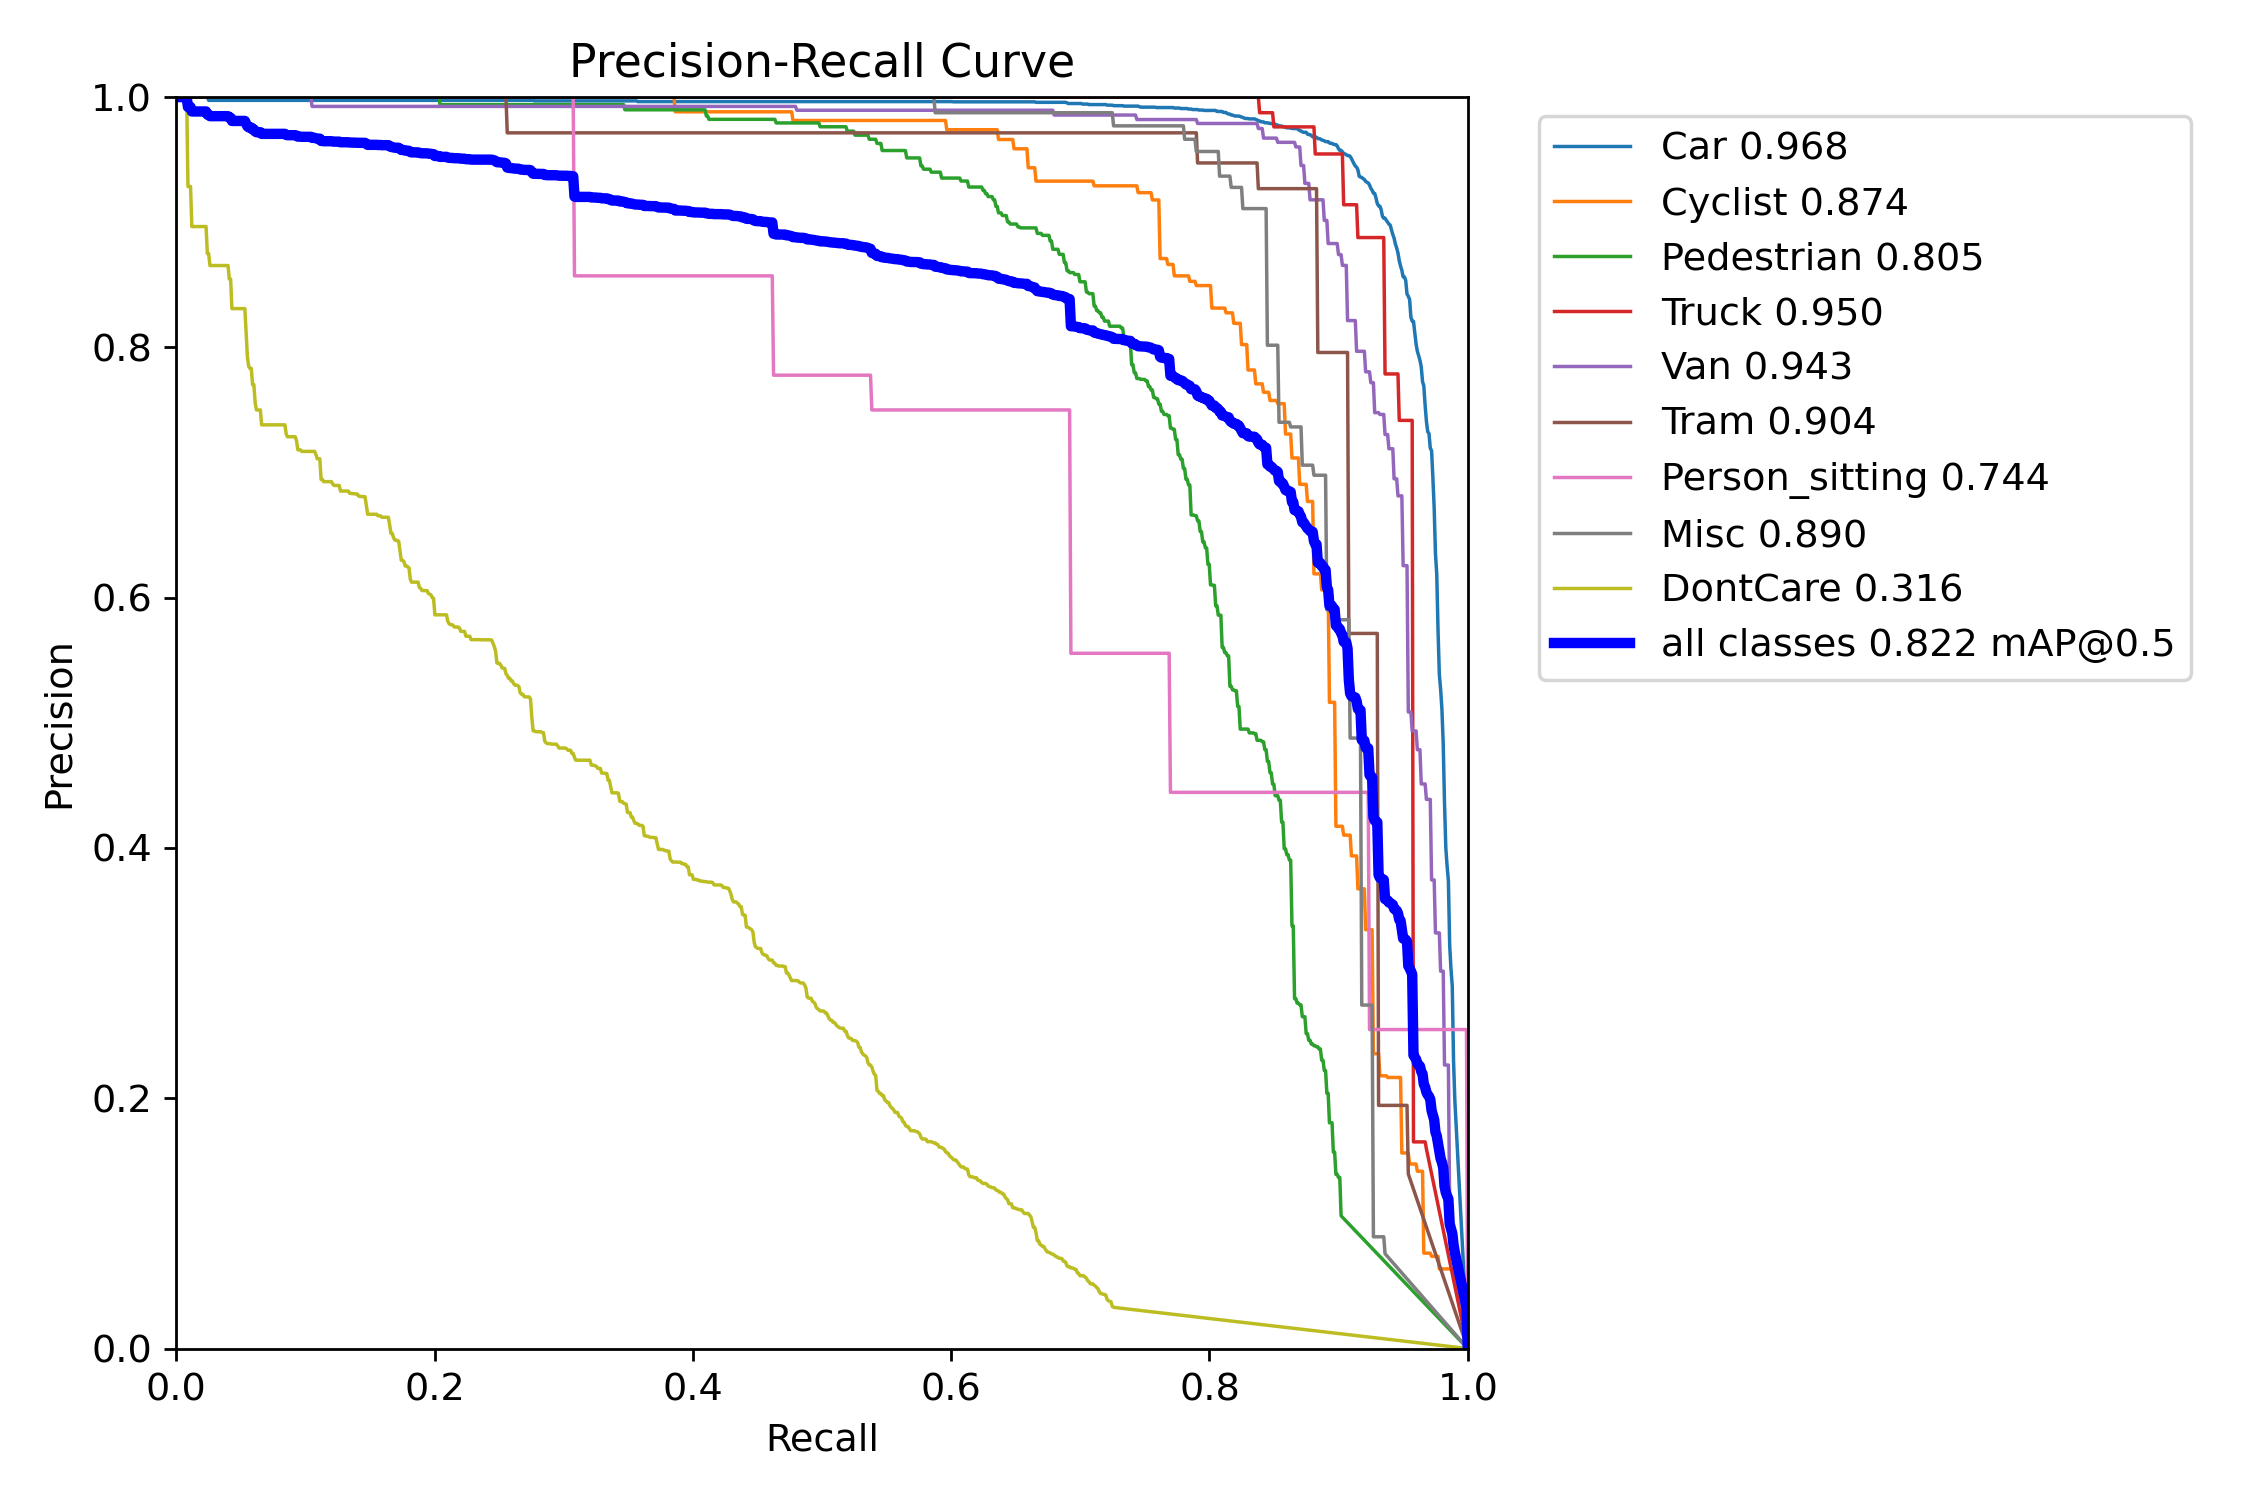

A curve that is closer to the top-right corner means it is a better prediction. Here we see that the model is best at detecting car (light blue), truck (red), and van (purple). Its ability to detect all classes (bold dark blue line) is 0.822 mAP@0.5. It means that the bounding boxes of its prediction has an overlap of 50% with the ground truth bounding boxes 82.2% of the time on average.

# F1-Confidence Curve

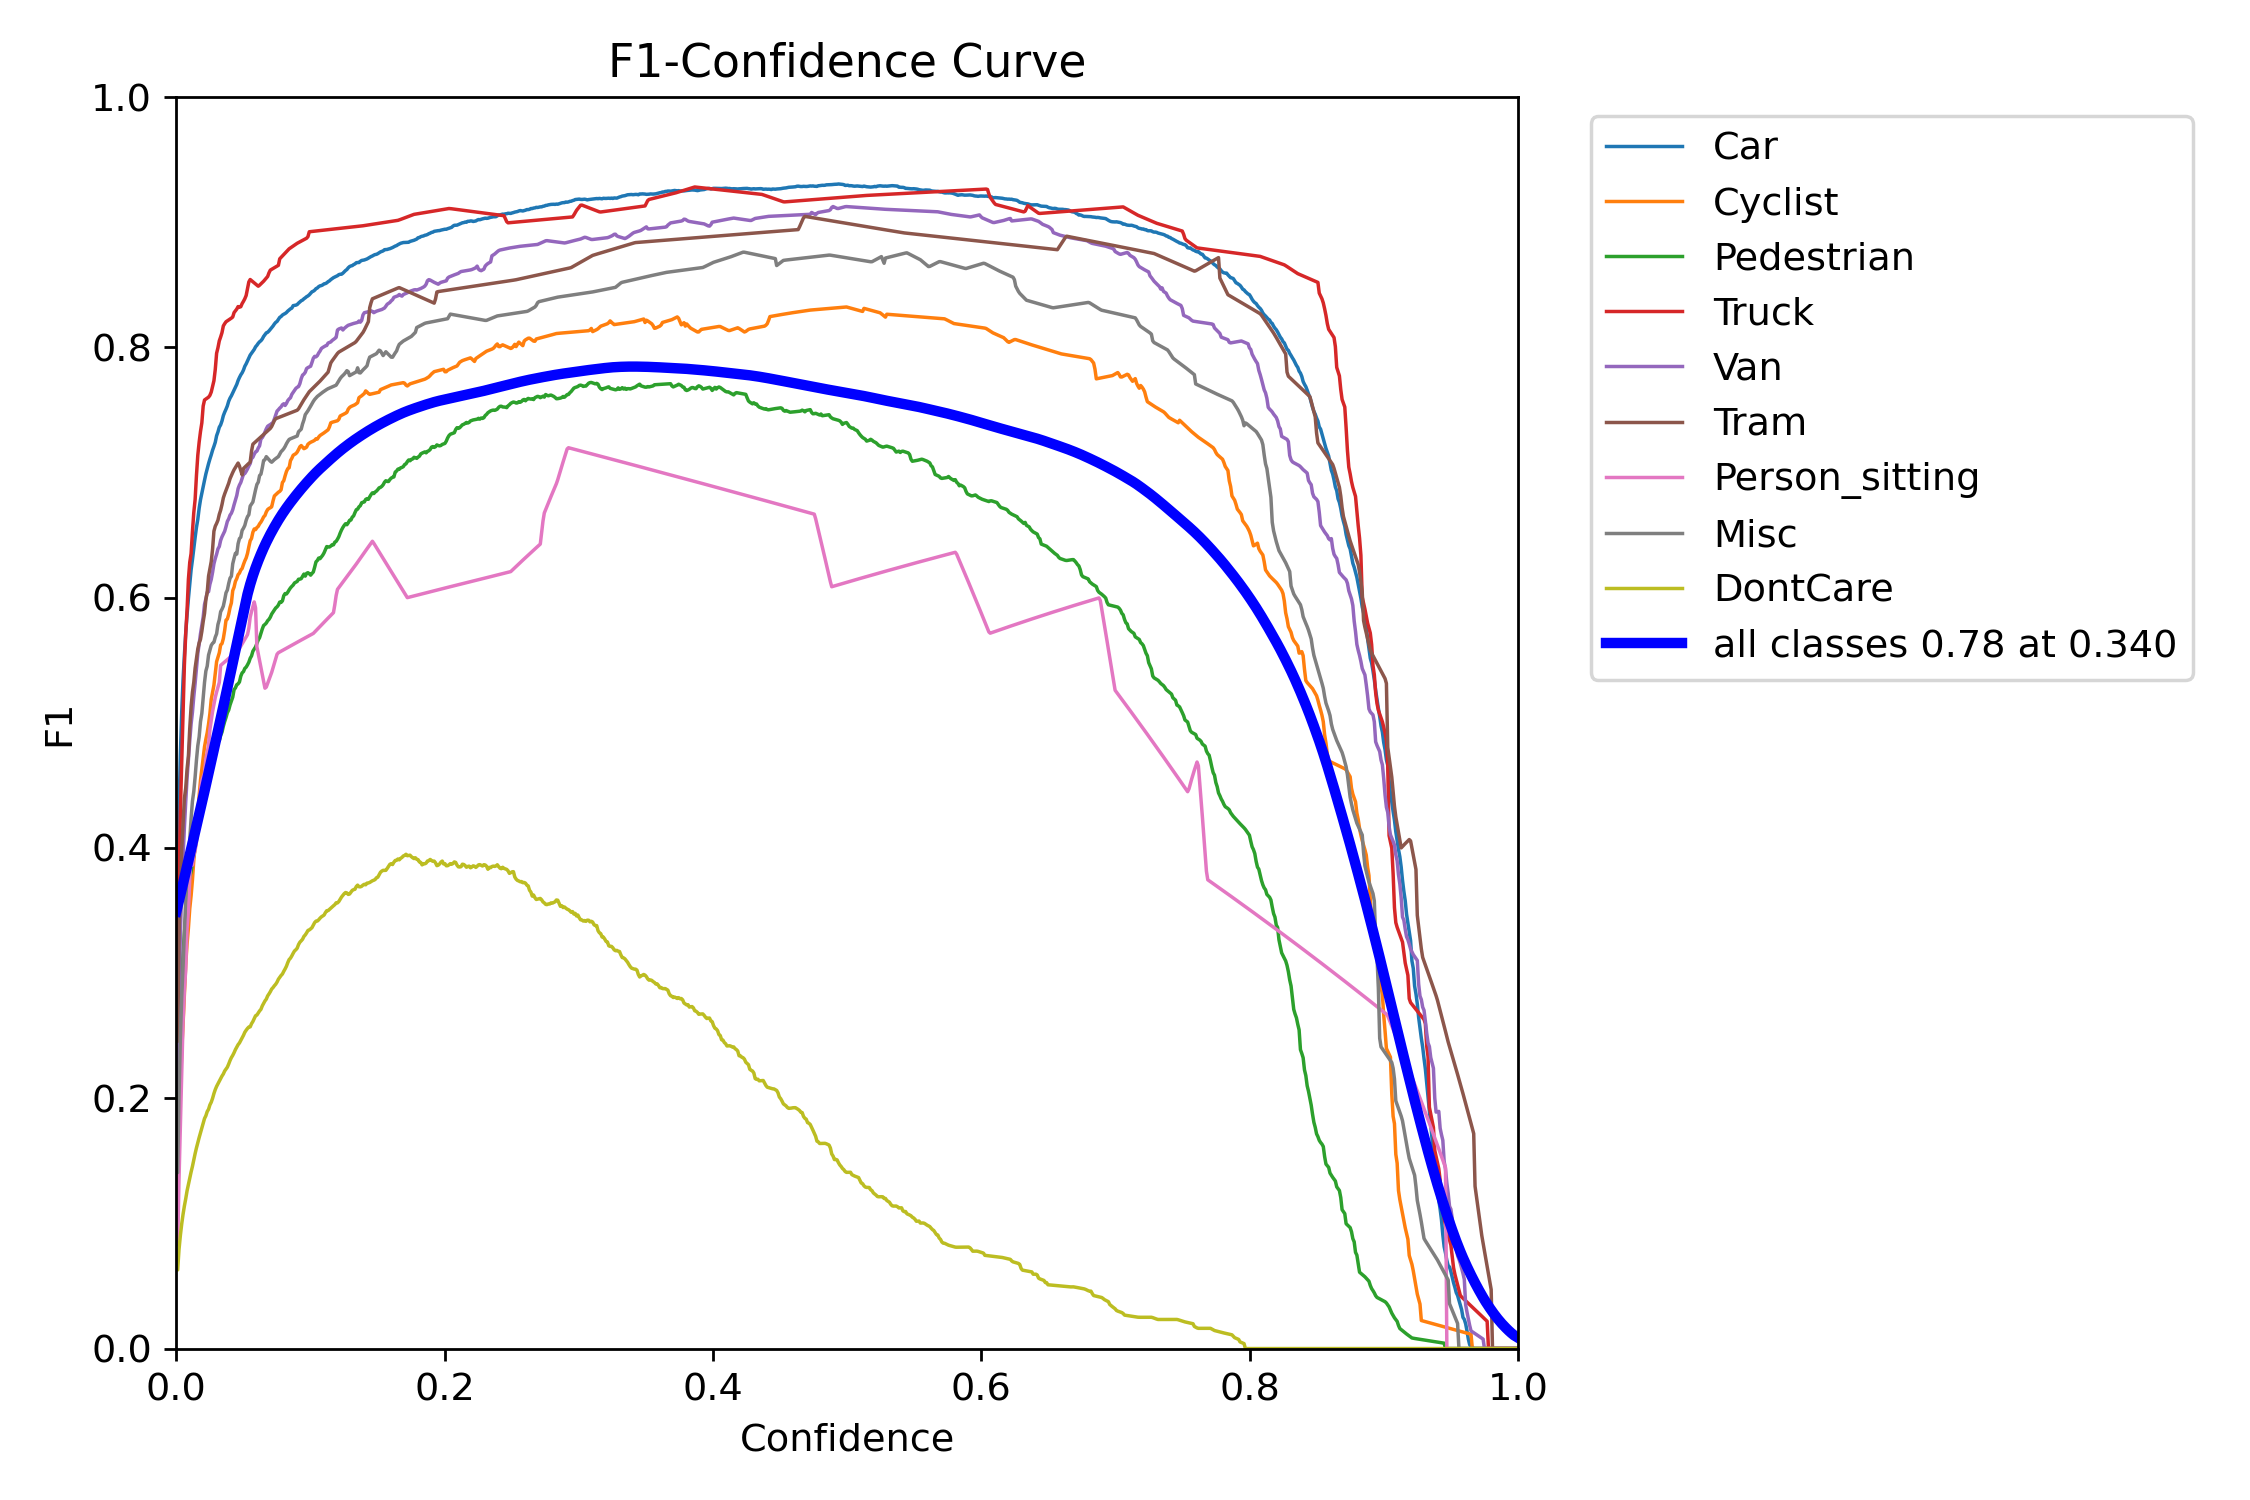

A curve with higher F1 indicates a better performance. As we saw in the previous PR curve, the model did best at classifying car, truck, and van than others. However, the F1-Confidence curve also shows the width of the peak of the curves. The curves for car (light blue), truck (red), and van (purple) are not only the highest but also the widest, which indicate that the F1 scores are relatively stable across the confidence threshold from lowest confidence to high confidence.

# Confusion Matrix (Normalized)

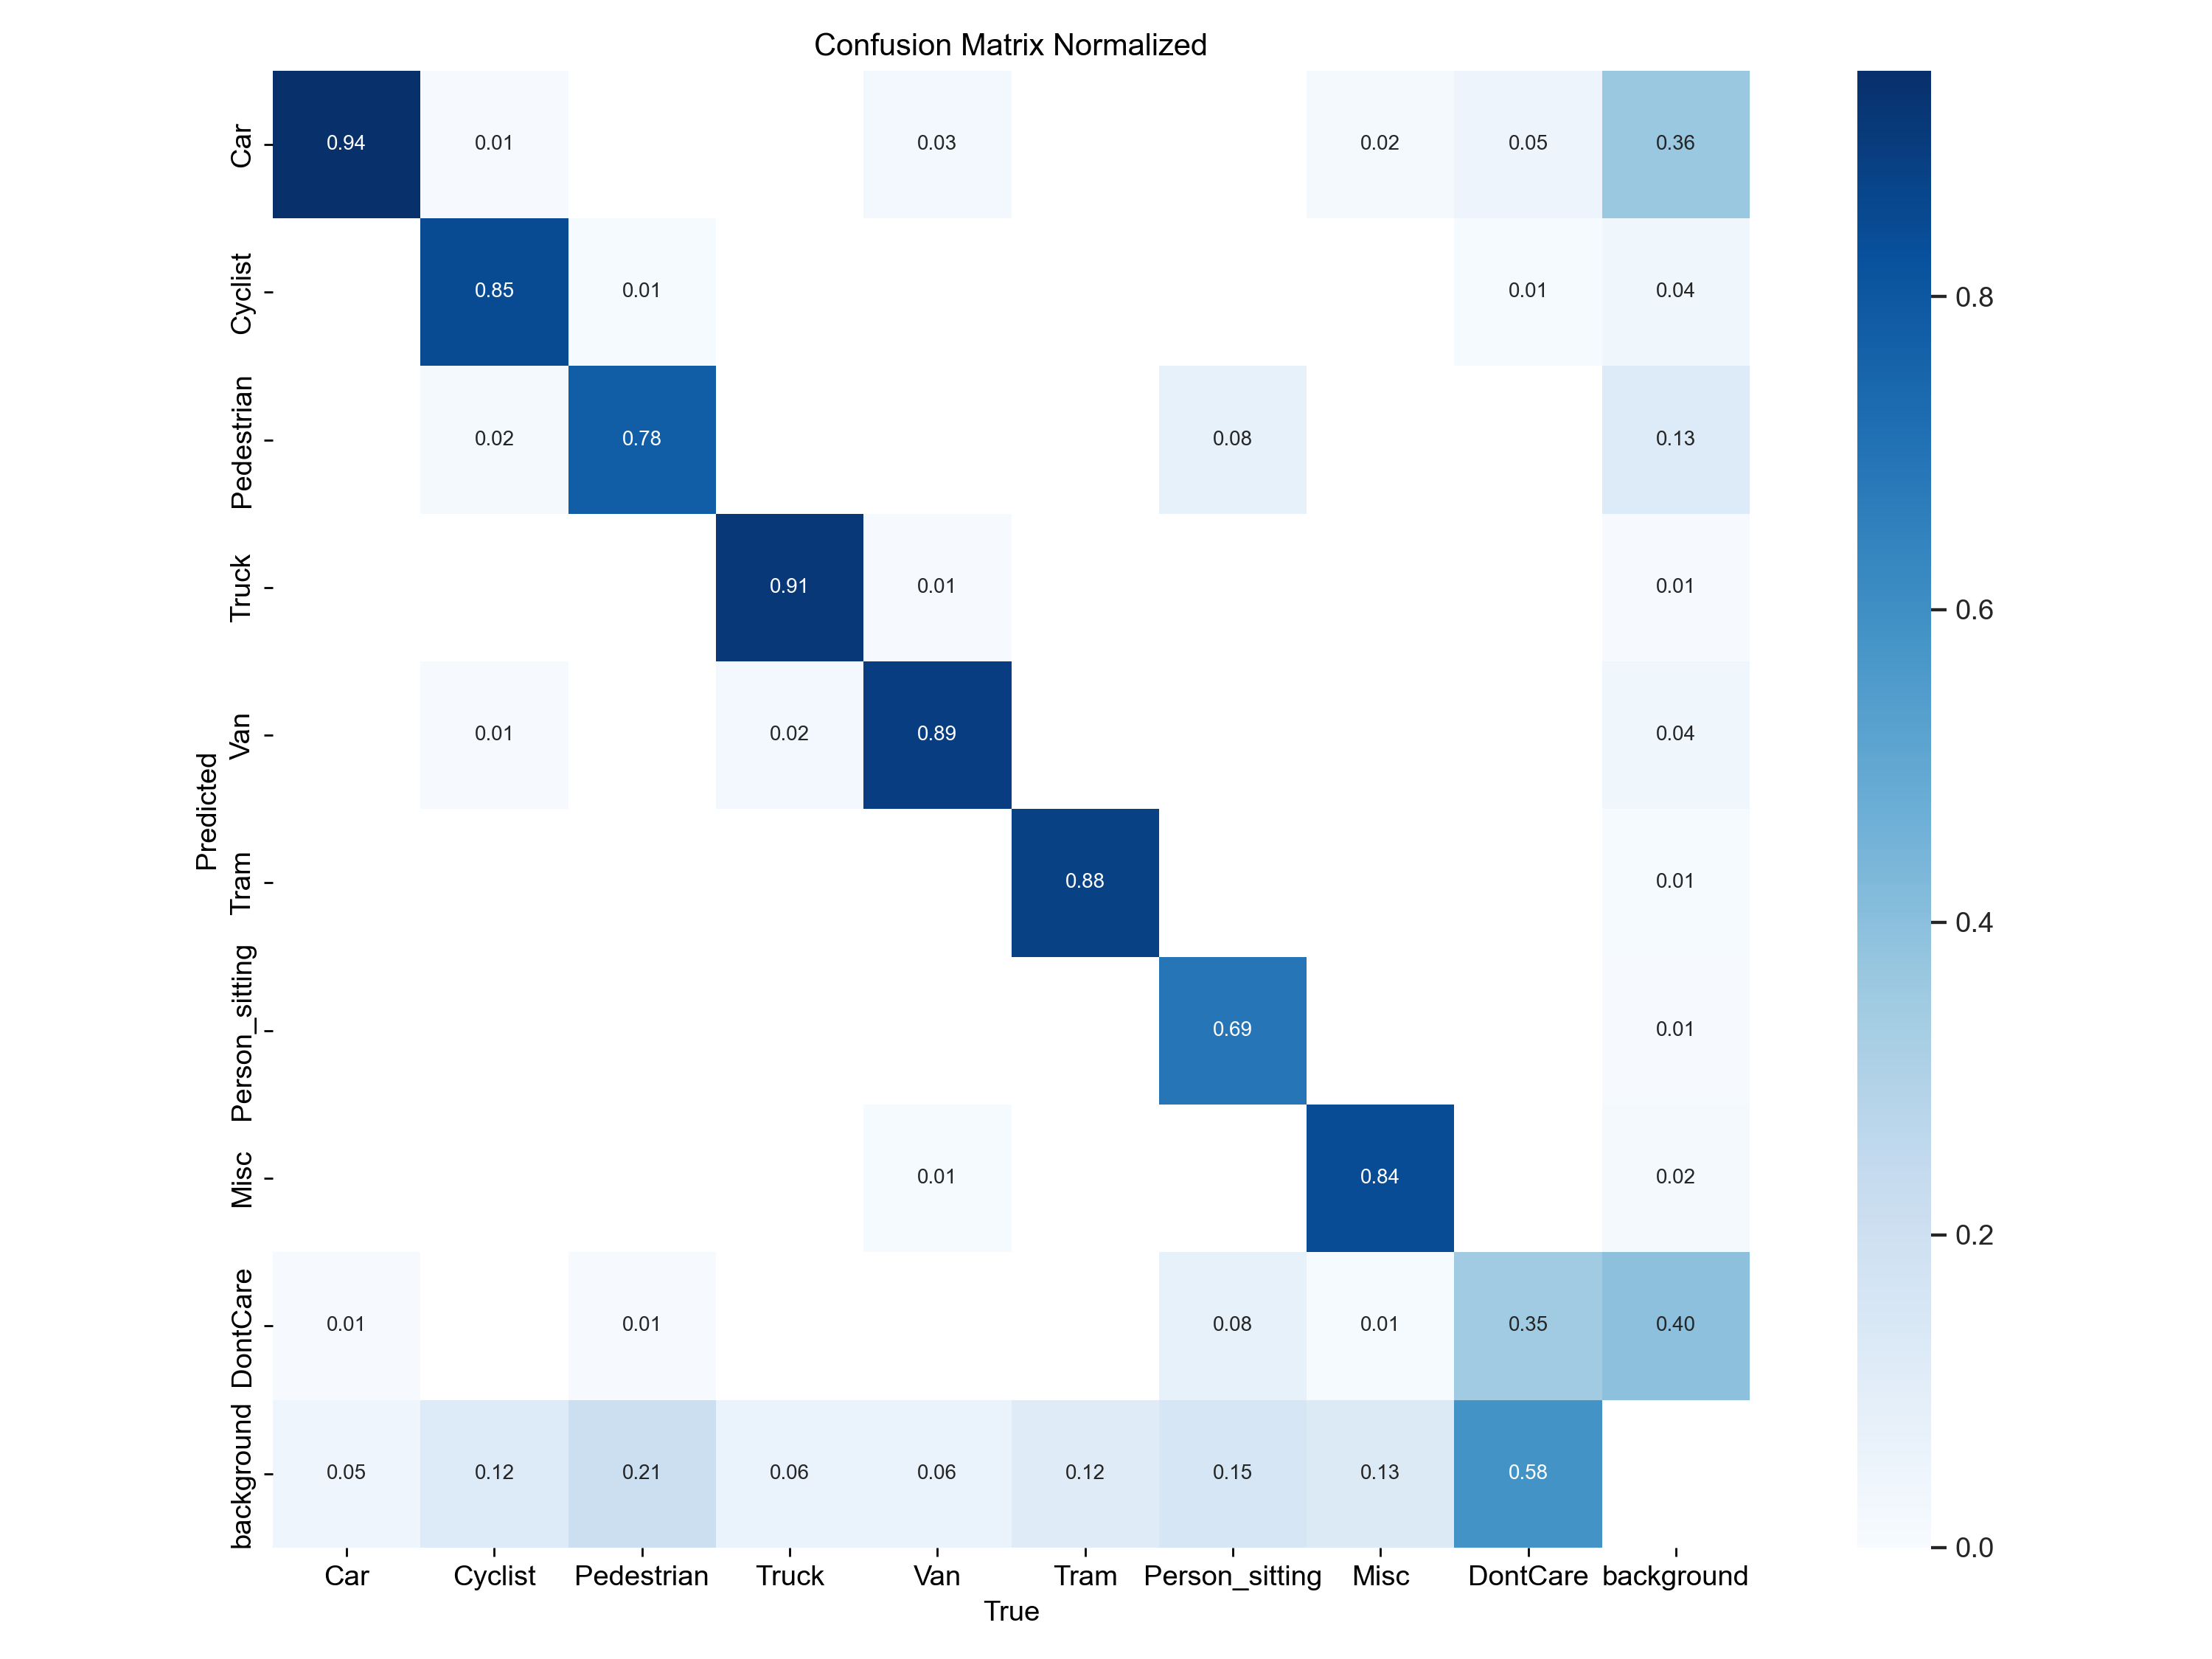

The confusion matrix agrees with the previous curves, that the model is best at classifying car, truck, and van. For car, 94% is classified as car, 5% as background, and 1% as DontCare. We can also see that the model is not that good at classifying Person_sitting, DontCare, and Background. For Person_sitting, 15% is classified as background, 8% as DontCare, and 8% as Pedestrian.

# Test Images with Ground Truth Labels

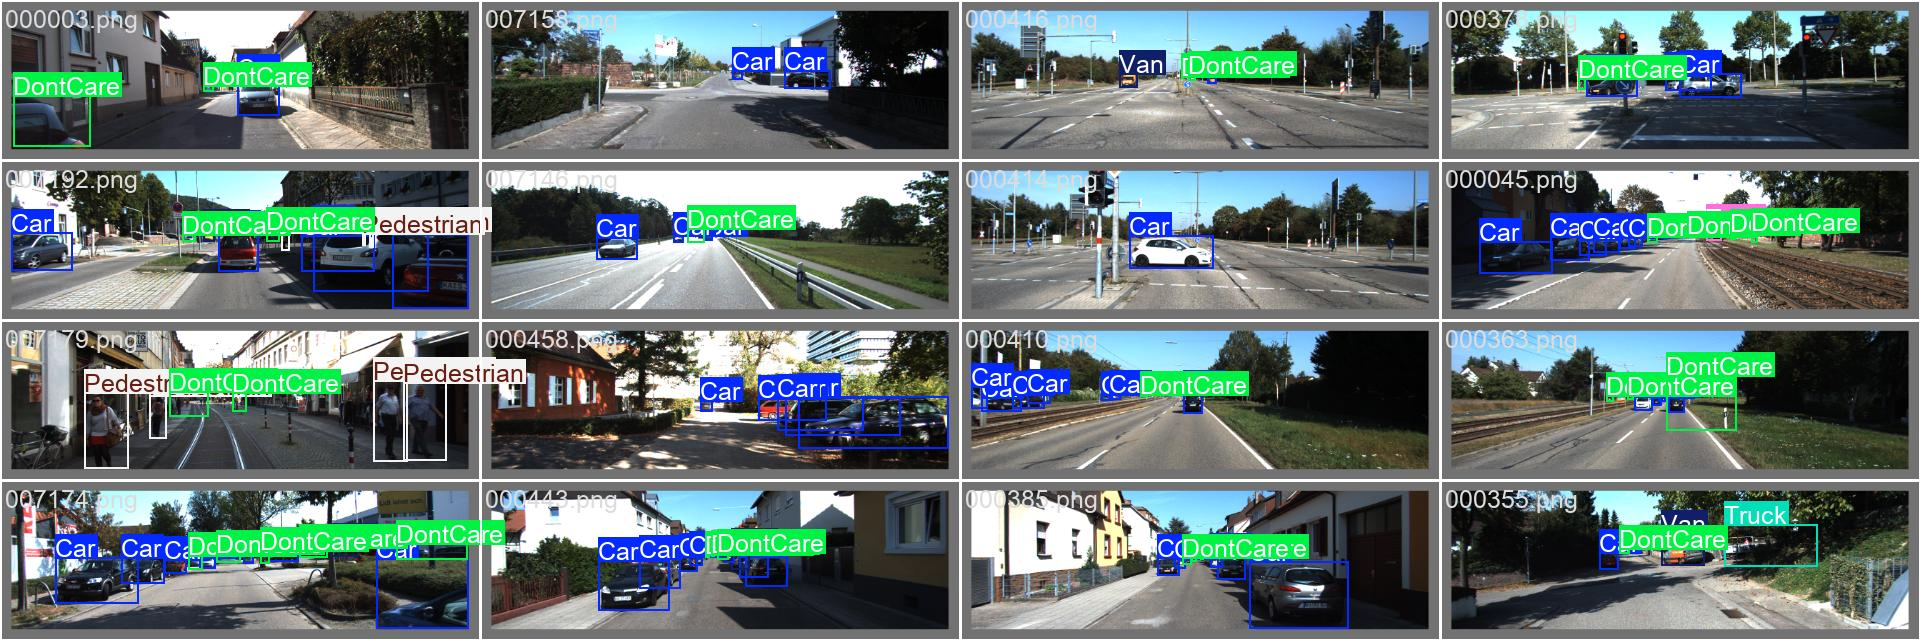

# Test Images with Prediction

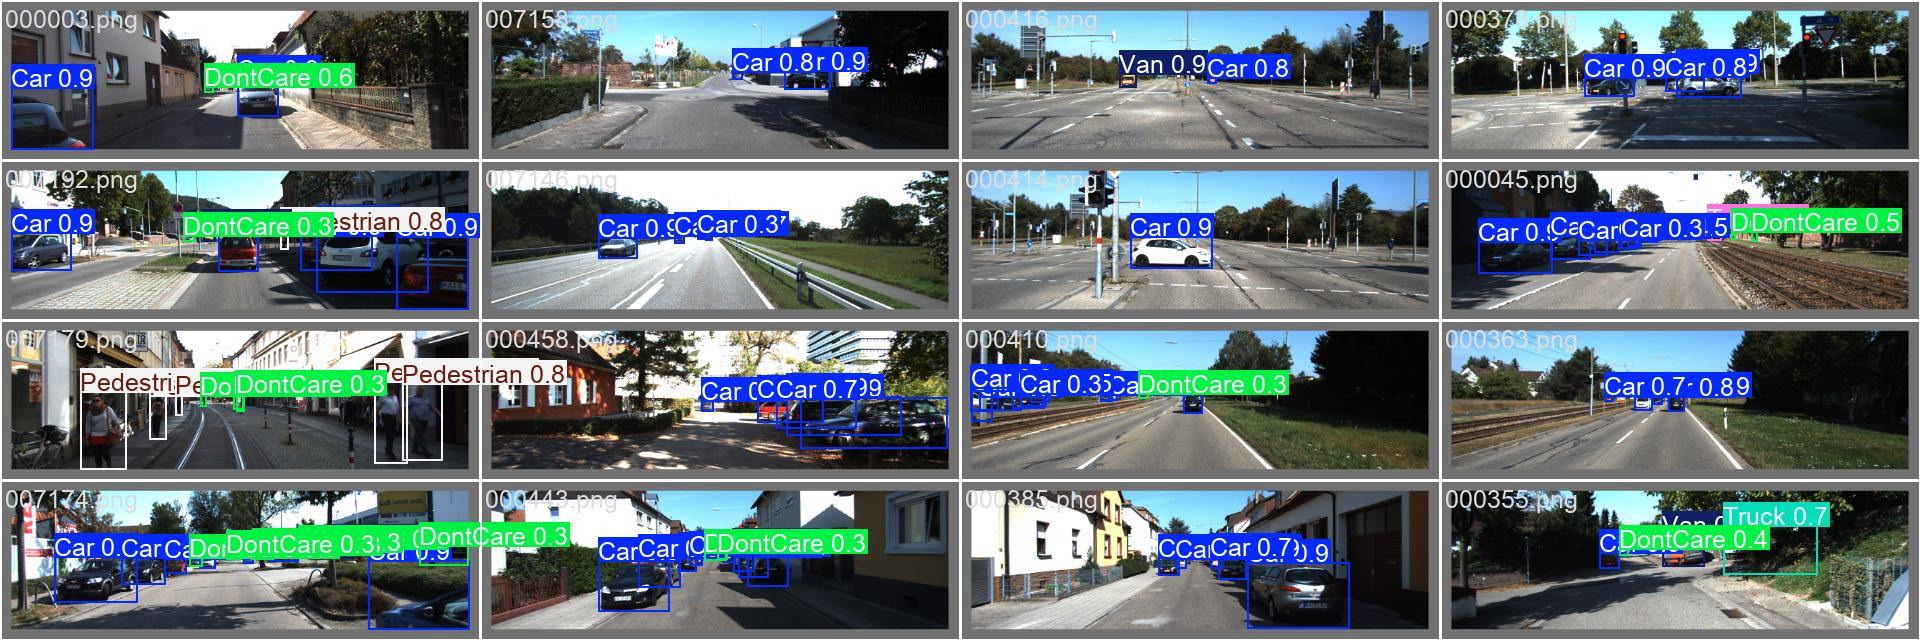

Here we also show the model's prediction on a few of the test images. We can see that model is better at classifying cars, trucks, and vans than others.

# **Conclusion**

In this project, we performed object detection task for autonomous driving. We used YOLOv8n on the KITTI dataset. The dataset has 9 classes and we found that our model is best at classifying cars, trucks, and vans.

# **References**

[1] A. Geiger, P. Lenz, and R. Urtasun, "KITTI Vision Benchmark Suite," [Online]. Available: https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d

[2] G. Jocher, A. Chaurasia, and J. Qiu, "Ultralytics YOLOv8, version 8.0.0," 2023. [Online]. Available: https://github.com/ultralytics/ultralytics
